# Non linear model ($L_e(d), Bl(d), K_m(d)$)

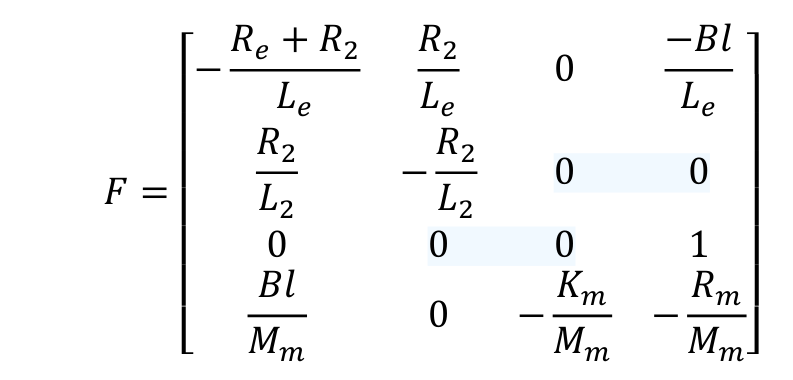

- valg af fs ud fra F?
- 

## Euler

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Minimum fs: 13027.62
fs: 65138
len samples: 325690
nperseg = 21712.666666666668
len seconds: 5.0
Num avg: 30.000921149594696
freq res: 3.0000921149594695


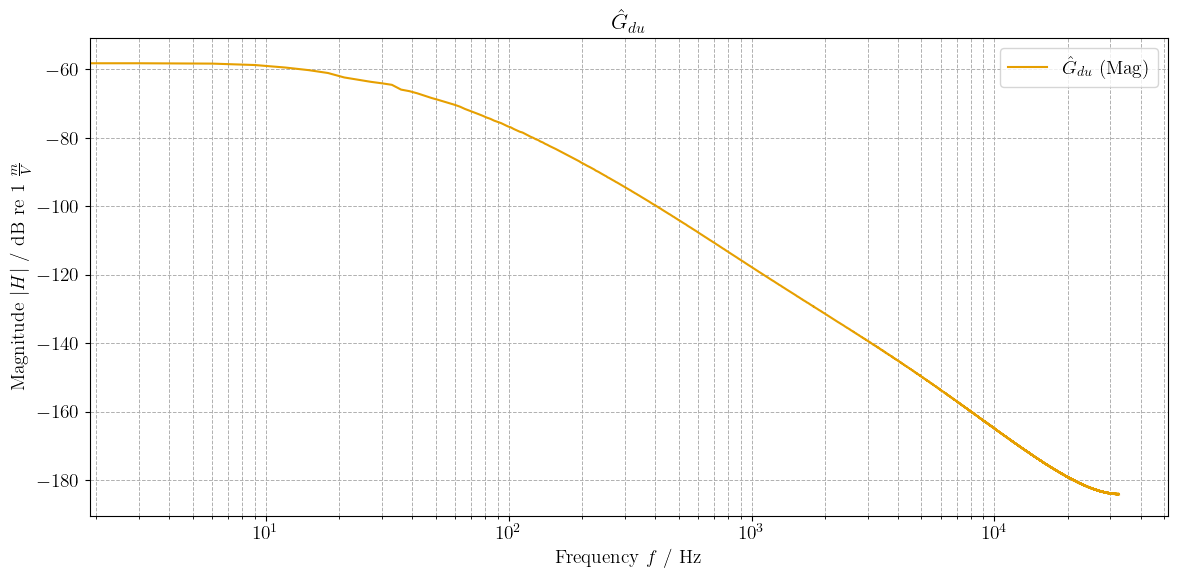

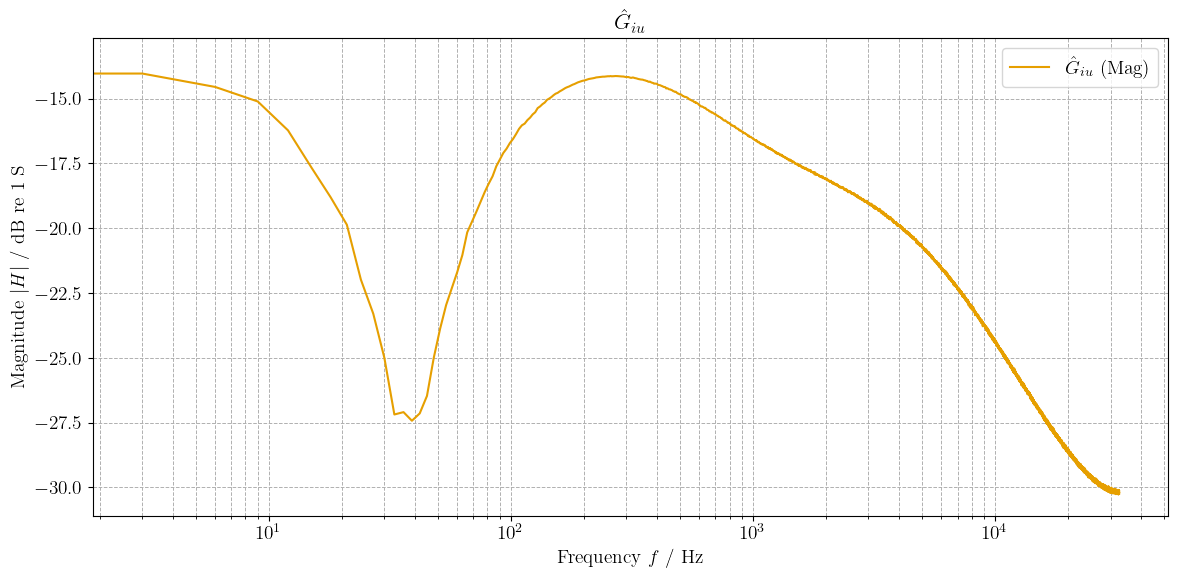

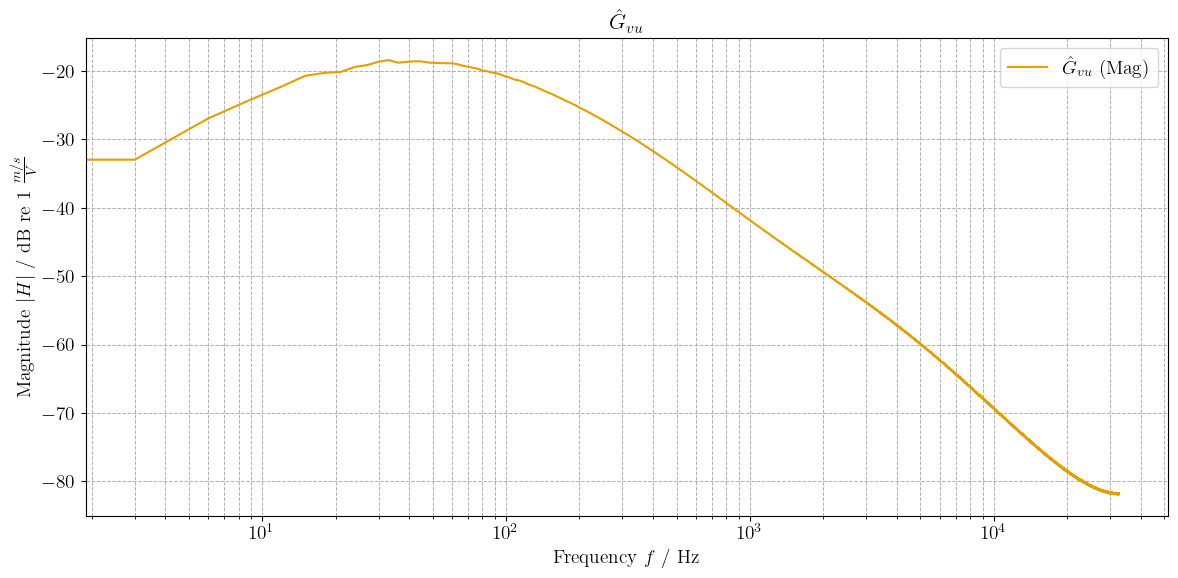

In [ ]:
%load_ext autoreload
%autoreload 2
import util
from scipy.io import wavfile
import matplotlib.pyplot as plt
import numpy as np 
import engutil


def solve_nonlinear_euler(u_signal, x0, fs, params, polys):
    """
    params = {
    'Re':  R_e,
    'Rm':  R_m,
    'Mm':  M_m,
    'R20': R_20,
    'L20': L_20

}

polys = {
    'Bl': poly_Bl,
    'K':  poly_K,
    'Le': poly_Le,
    'Li': poly_Li
}

where poly_Bl =poly_Bl = np.poly1d(Bln)

    """
    Ts = 1.0 / fs
    num_steps = len(u_signal)
    num_states = len(x0)
    
    # output:
    x_history = np.zeros((num_steps, num_states))
    x_curr = x0.copy()
    
    # static values
    Re = params['Re']
    R20 = params['R20']
    L20 = params['L20']
    Mm = params['Mm']
    Rm = params['Rm']
    
    # init matrices
    F = np.zeros((4, 4))
    G = np.zeros(4)
    
    # static parts of F
    
    F[2, 3] = 1.0
    F[3, 3] = -Rm / Mm
    
    for n in range(num_steps):
        x_history[n] = x_curr
        
        # i, i_L2, displacement, velocity
        i_curr = x_curr[0]
        disp   = x_curr[2] # grab displacement value
        
        # update polynomial values
        val_Bl = polys['Bl'](disp)
        val_K  = polys['K'](disp)
        val_Le = polys['Le'](disp)*polys["Li"](disp)
        val_R2 = R_20*val_Le/polys['Le'](0)
        val_L2 = L_20*val_Le/polys['Le'](0)

        # L_e = Ln*Li 
        # R_2 = R_20*L_e/L_e0
        # L_2 = L_20*L_e/L_e0

        # val_L2 = polys['Li'](disp)

        # val_Le = max(val_Le, 1e-6) 
        # val_L2 = max(val_Li, 1e-6)
        
        # # update F whereever it needs updating
        # F[0, 0] = -(Re + R20) / val_Le
        # F[0, 1] = R20 / val_Le
        # F[0, 3] = -val_Bl / val_Le
        
        # F[1, 0] = R20 / val_L2
        # F[1, 1] = -R20 / val_L2

        # F[3, 0] = val_Bl / Mm
        # F[3, 2] = -val_K / Mm


        F[0, 0] = -(Re + val_R2) / val_Le
        F[0, 1] = val_R2 / val_Le
        F[0, 3] = -val_Bl / val_Le
        
        F[1, 0] = val_R2 / val_L2
        F[1, 1] = -val_R2 / val_L2

        F[3, 0] = val_Bl / Mm
        F[3, 2] = -val_K / Mm



        G[0] = 1.0 / val_Le
        
        # do the Euler!
        dx = (F @ x_curr) + (G * u_signal[n])
        
        x_next = x_curr + (dx * Ts)
        x_curr = x_next
        
    return x_history


## Params from Python driven with 3Vrms pink noise
Bl=6.837193705842441
R_e=4.822146670305587
R_m=2.2833222074164836
K_m=1107.8705431240523
L_e0 =0.000305207582223968
M_m=0.020004906958875274
L_20=0.0004325286577462285
R_20=2.504536634680621

Bln=[
-2615563718.9455967,
-3023090.98130258,
-9835.616494456142,
21.171849188494026, 
Bl]

Kn=[
    1724760519892.831,
    -5658865945.33859,
    35715360.4027017,
    -210546.86882586573,
    K_m
] 
Ln=[
    20081.188591764963,
    -319.17779393260366,
    0.8155679039802962,
    -0.01018945289267653,
    L_e0
]
Li=[
    -0.0012237427320541485,
    -0.0014189369785025077,
    0.007354393550658496,
    0.005954177167801685,
    1
]
# L_e = Ln*Li 
# R_2 = R_20*L_e/L_e0
# L_2 = L_20*L_e/L_e0

    
# p = np.poly1d([1, 2, 3])
# coeffs from Bln is Bln[0] * x**4  Bln[1] * x**3 + Bln[2] * x**2 (...) + Bl
poly_Bl = np.poly1d(Bln)
poly_K  = np.poly1d(Kn)
poly_Le = np.poly1d(Ln) 
poly_Li = np.poly1d(Li)

F_linear_static = np.array([
    [-(R_e + R_20)/L_e0,  R_20/L_e0,    0.0,         -Bl/L_e0],
    [R_20/L_20,          -R_20/L_20,    0.0,          0.0 ],
    [0.0,                   0.0,            0.0,          1.0],
    [Bl/M_m,                0.0,           -K_m/M_m,   -R_m/M_m ]
])

duration = 5

minimum_fs = util.calculate_min_fs(F_linear_static)
print(f"Minimum fs: {minimum_fs:.2f}")
fs = int(5*minimum_fs)
print(f"fs: {fs}")
# 1. create input signal
u = util.generate_pink_noise(fs*duration, fs, fmin=1)

# prepare data
params = {
    'Re':  R_e,
    'Rm':  R_m,
    'Mm':  M_m,
    'R20': R_20,
    'L20': L_20
}

polys = {
    'Bl': poly_Bl,
    'K':  poly_K,
    'Le': poly_Le,
    'Li': poly_Li
}

x0 = np.array([0,0,0,0]) # initial conditions
x = solve_nonlinear_euler(u, x0, fs, params, polys)
X = np.array([x[:,0], x[:,2], x[:,3]])

G_iu, G_du, G_vu, f = util.welchie(u, X, fs)

G_iu_mag_db, G_iu_phase, G_iu_mag_lin  = engutil.tf_to_magphase(G_iu)
G_du_mag_db, G_du_phase, G_du_mag_lin  = engutil.tf_to_magphase(G_du)
G_vu_mag_db, G_vu_phase, G_vu_mag_lin  = engutil.tf_to_magphase(G_vu)

engutil.plot_bode(f, [(G_du_mag_db, None)], legends=["$\\hat{G}_{du}$"], title="$\\hat{G}_{du}$", ylabel_left="Magnitude $\\left| H \\right|$ / dB re 1 $\\frac{m}{V}$")
engutil.plot_bode(f, [(G_iu_mag_db, None)], legends=["$\\hat{G}_{iu}$"], title="$\\hat{G}_{iu}$", ylabel_left="Magnitude $\\left| H \\right|$ / dB re 1 S")
engutil.plot_bode(f, [(G_vu_mag_db, None)], legends=["$\\hat{G}_{vu}$"], title="$\\hat{G}_{vu}$", ylabel_left="Magnitude $\\left| H \\right|$ / dB re 1 $\\frac{m/s}{V}$")


## ODE45

In [ ]:
import numpy as np
from scipy.integrate import solve_ivp
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
import util
import os
import engutil

def loudspeaker_ode(t, x, u_func, params, polys):
    i_curr = x[0]  
    i_creep = x[1] 
    disp = x[2]    
    vel = x[3]    
    
    voltage = u_func(t) # input voltage
    
    # values from Bl, K and Le polynomials
    val_Bl = polys['Bl'](disp)
    val_K  = polys['K'](disp)
    val_Le_base = polys['Le'](disp) * polys['Li'](disp)
    val_Le = max(val_Le_base, 1e-9) # ensure there will be no divide by 0

    Le_nominal = polys['Le'](0) # x = 0 value of Le
    ratio = val_Le / Le_nominal
    
    # scale R2 and L2 accordingly
    val_R2 = params['R20'] * ratio
    val_L2 = params['L20'] * ratio
    
    # equation 0: di/dt = (1/Le) * (V - (Re+R2)i + R2*i2 - Bl*v)
    di_dt = (1.0 / val_Le) * (voltage - (params['Re'] + val_R2)*i_curr + val_R2*i_creep - val_Bl*vel)
    
    # equation 1: di2/dt = (1/L2) * (R2*i - R2*i2)
    di2_dt = (val_R2 / val_L2) * (i_curr - i_creep)
    
    # equation 2: d(disp)/dt = vel
    ddisp_dt = vel
    
    # equation 3: d(vel)/dt = (1/Mm) * (Bl*i - K*x - Rm*v)
    dvel_dt = (1.0 / params['Mm']) * (val_Bl*i_curr - val_K*disp - params['Rm']*vel)
    
    return [di_dt, di2_dt, ddisp_dt, dvel_dt]

# setup params
Bl = 6.837193705842441
R_e = 4.822146670305587
R_m = 2.2833222074164836
K_m = 1107.8705431240523
L_e0 = 0.000305207582223968
M_m = 0.020004906958875274
L_20 = 0.0004325286577462285
R_20 = 2.504536634680621

Bln = [-2615563718.9455967, -3023090.98130258, -9835.616494456142, 21.171849188494026, Bl]
Kn  = [1724760519892.831, -5658865945.33859, 35715360.4027017, -210546.86882586573, K_m]
Ln  = [20081.188591764963, -319.17779393260366, 0.8155679039802962, -0.01018945289267653, L_e0]
Li  = [-0.0012237427320541485, -0.0014189369785025077, 0.007354393550658496, 0.005954177167801685, 1]

# polys = {
#     'Bl': np.poly1d(Bln),
#     'K':  np.poly1d(Kn),
#     'Le': np.poly1d(Ln),
#     'Li': np.poly1d(Li)
# }

params = {
    'Re': R_e, 'Rm': R_m, 'Mm': M_m, 'R20': R_20, 'L20': L_20, 'Le_nom': L_e0
}

# for calculating min fs
F_linear_static = np.array([
    [-(R_e + R_20)/L_e0,  R_20/L_e0,    0.0,         -Bl/L_e0],
    [R_20/L_20,          -R_20/L_20,    0.0,          0.0 ],
    [0.0,                   0.0,            0.0,          1.0],
    [Bl/M_m,                0.0,           -K_m/M_m,   -R_m/M_m]
])

minimum_fs = util.calculate_min_fs(F_linear_static)
print(f"Minimum Linear fs: {minimum_fs:.2f}")

# duration 2 and 3 * min fs tog ~4min
duration = 5.0
fs = int(5 * minimum_fs)
t_eval = np.linspace(0, duration, int(fs*duration))
u = util.generate_pink_noise(len(t_eval), fs, fmin=1)

# u(t) function - ie to be able to find values between sample values.. 
u_func = interp1d(t_eval, u, kind='linear', fill_value="extrapolate")


scenarios = [
    # {
    #     "name": "01_linear",
    #     "polys": {
    #         'Bl': np.poly1d([Bl]), # Scalar -> Constant
    #         'K':  np.poly1d([K_m]),
    #         'Le': np.poly1d([L_e0]),
    #         'Li': np.poly1d([1])
    #     }
    # },
    {
        "name": "01_nonlinear_full",
        "polys": {
            'Bl': np.poly1d(Bln),
            'K':  np.poly1d(Kn),
            'Le': np.poly1d(Ln),
            'Li': np.poly1d(Li)
        }
    },
    {
        "name": "02_nonlinear_stiffness_only", # Example of a 3rd variation
        "polys": {
            'Bl': np.poly1d([Bl]), # Constant Bl
            'K':  np.poly1d(Kn),       # Non-linear Stiffness
            'Le': np.poly1d([L_e0]),   # Constant Le
            'Li': np.poly1d([1])
        }
    },
    {
        "name": "03_nonlinear_Bl_only",
        "polys": {
            'Bl': np.poly1d(Bln), #Nonlinear Bl
            'K':  np.poly1d([K_m]),       
            'Le': np.poly1d([L_e0]),  
            'Li': np.poly1d([1])
        }
    },
    {
        "name": "04_nonlinear_Le_only",
        "polys": {
            'Bl': np.poly1d([Bl]),
            'K':  np.poly1d([K_m]),       
            'Le': np.poly1d(Ln), # non linear bl  
            'Li': np.poly1d(Li)
        }
    },

]

output_dir = "data/part2_simulations"
os.makedirs(output_dir, exist_ok=True)

x0 = [0, 0, 0, 0] # Initial conditions

for case in scenarios:
    print(f"Running simulation: {case['name']} ...")
    
    current_polys = case['polys']
    
    sol = solve_ivp(
        fun=loudspeaker_ode,
        t_span=(0, duration),
        y0=x0,
        t_eval=t_eval,      
        args=(u_func, params, current_polys), 
        method='RK45',      
        rtol=1e-1,       # 1e-3   (was 5)
        atol=1e-2        # 1e-6 ( was 8)
    )
    
    # Organize data for saving
    # Structure: [Time, voltage, Current, Creep_Current, Displacement, Velocity
    data_to_save = np.vstack((sol.t, u, sol.y)).T
    
    filename = f"{output_dir}/{case['name']}.csv"
    
    # Save with header
    np.savetxt(
        filename, 
        data_to_save, 
        delimiter=",", 
        header="time,u,i,i_creep,disp,vel",
        comments="" # Removes the '#' usually added to headers by numpy
    )
    
    print(f"Saved: {filename}")

print("All simulations complete.")






# polys = {
#     'Bl': np.poly1d(Bln),
#     'K':  np.poly1d(K_m),
#     'Le': np.poly1d(L_e0),
#     'Li': np.poly1d(1)
# }


# x0 = [0, 0, 0, 0]

# sol = solve_ivp(
#     fun=loudspeaker_ode,
#     t_span=(0, duration),
#     y0=x0,
#     t_eval=t_eval,      
#     args=(u_func, params, polys), 
#     method='RK45',      
#     rtol=1e-5,         
#     atol=1e-8           
# )

# x_history = sol.y.T 

# X = np.array([x_history[:,0], x_history[:,2], x_history[:,3]])

# X_saved = np.array([x_history[:,0], x_history[:,1], x_history[:,2], x_history[:,3]])

# np.savetxt("data/part2 - non-linear-model/")


Minimum Linear fs: 13027.62
Running simulation: 01_nonlinear_full ...
Saved: data/part2_simulations/01_nonlinear_full.csv
Running simulation: 02_nonlinear_stiffness_only ...
Saved: data/part2_simulations/02_nonlinear_stiffness_only.csv
Running simulation: 03_nonlinear_Bl_only ...
Saved: data/part2_simulations/03_nonlinear_Bl_only.csv
Running simulation: 04_nonlinear_Le_only ...
Saved: data/part2_simulations/04_nonlinear_Le_only.csv
All simulations complete.


[ 0.         -0.00771594  0.01312064 ... -0.08860571 -0.06555273
 -0.05870765]


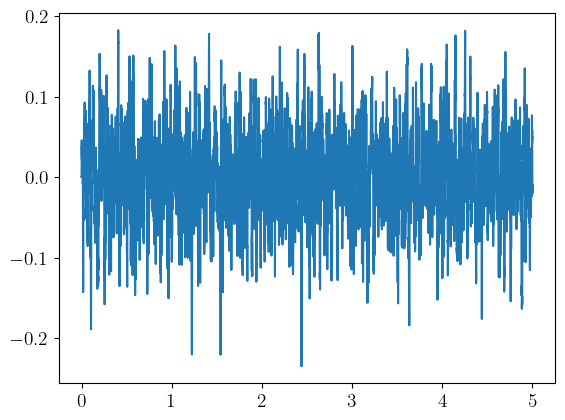

In [21]:
x_history = sol.y.T 

X = np.array([x_history[:,0], x_history[:,2], x_history[:,3]])
plt.figure()
plt.plot(t_eval, X[2])
print(X[0])

325690
65138
len samples: 325690
nperseg = 21712.666666666668
len seconds: 5.0
Num avg: 30.000921149594696
freq res: 3.0000921149594695


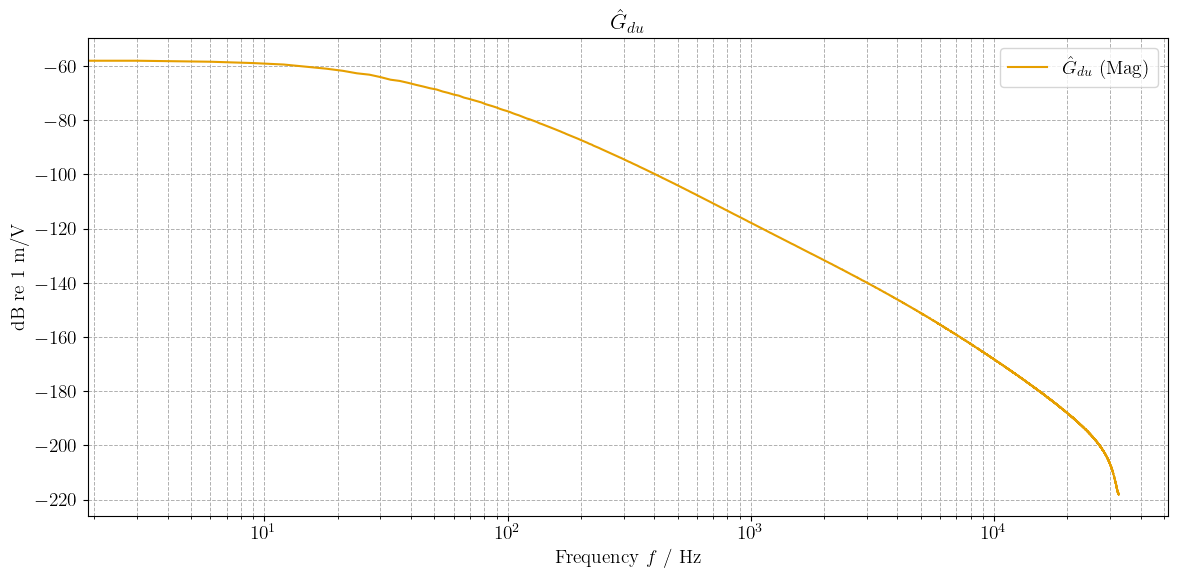

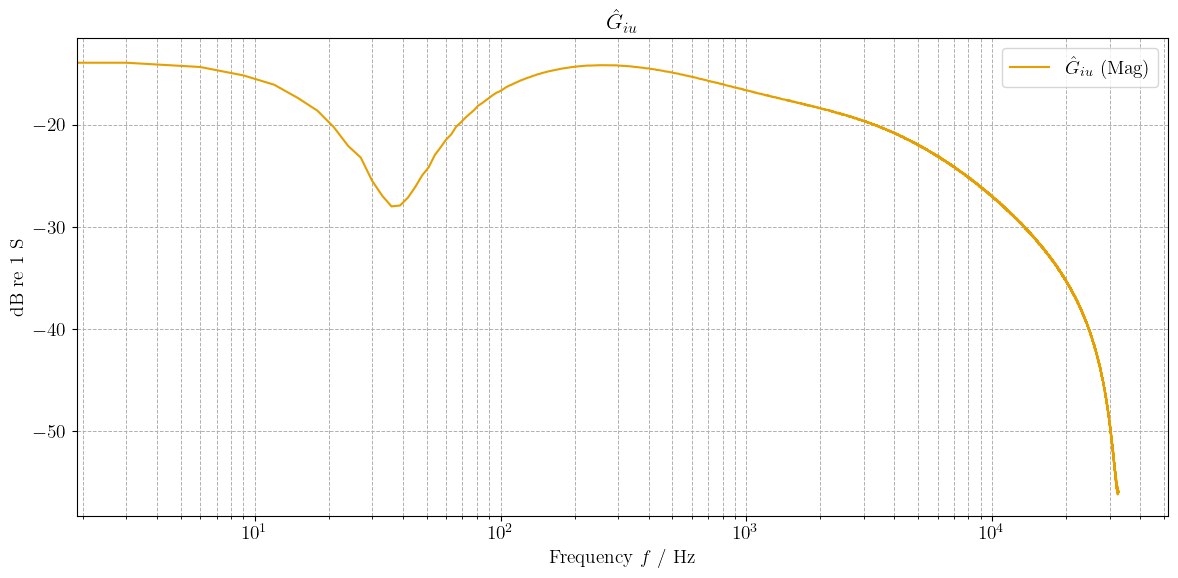

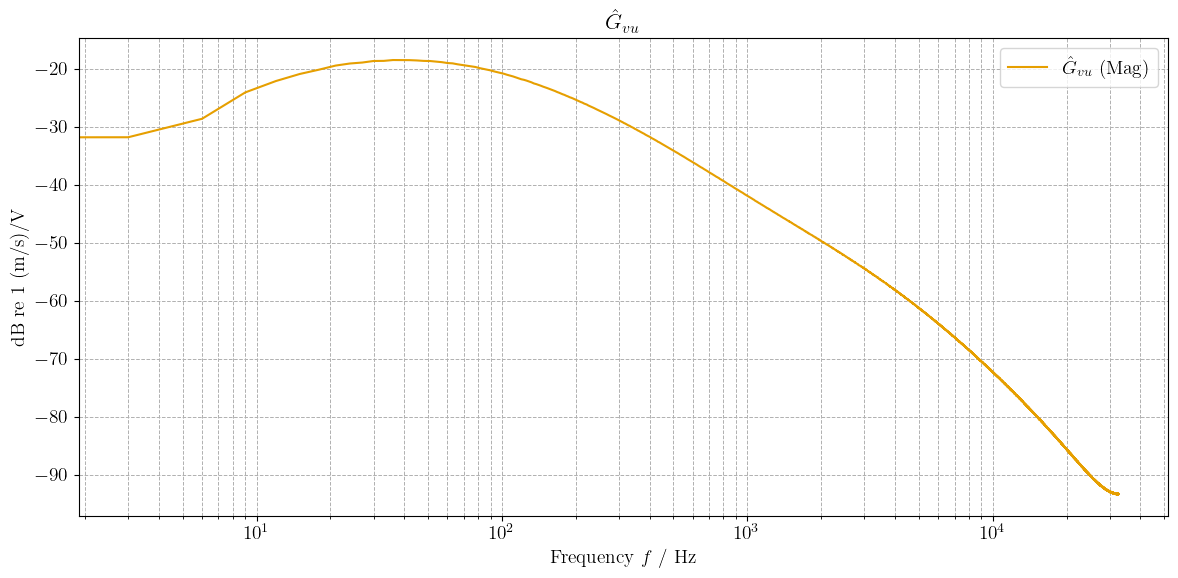

In [ ]:
print(len(u))
print(fs)
G_iu, G_du, G_vu, f = util.welchie(u, X, fs)
G_iu_mag_db, _, _ = engutil.tf_to_magphase(G_iu)
G_du_mag_db, _, _ = engutil.tf_to_magphase(G_du)
G_vu_mag_db, _, _ = engutil.tf_to_magphase(G_vu)

engutil.plot_bode(f, [(G_du_mag_db, None)], legends=["$\\hat{G}_{du}$"], title="$\\hat{G}_{du}$", ylabel_left="dB re 1 m/V")
engutil.plot_bode(f, [(G_iu_mag_db, None)], legends=["$\\hat{G}_{iu}$"], title="$\\hat{G}_{iu}$", ylabel_left="dB re 1 S")
engutil.plot_bode(f, [(G_vu_mag_db, None)], legends=["$\\hat{G}_{vu}$"], title="$\\hat{G}_{vu}$", ylabel_left="dB re 1 (m/s)/V")

In [5]:
import numpy as np
X_saved= np.array([x_history[:,0], x_history[:,1], x_history[:,2], x_history[:,3]])

np.savetxt("duration_5_sec_min_fs_5x.txt", X_saved)

## Plot of non linear params $Bl(x), K_m(x), L_e(x)$

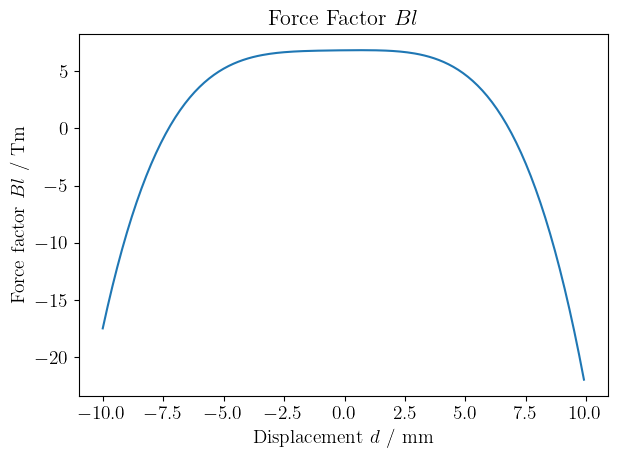

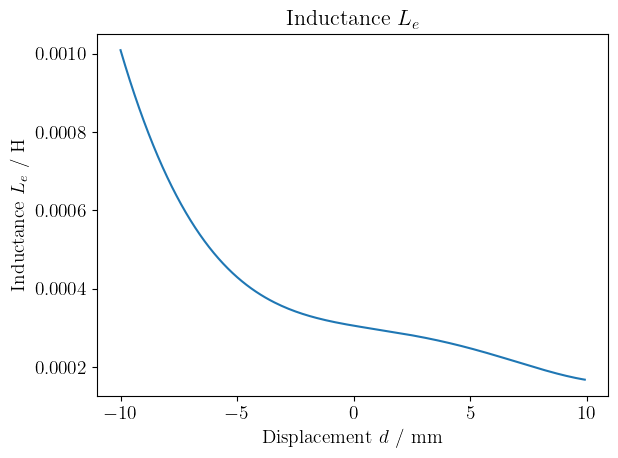

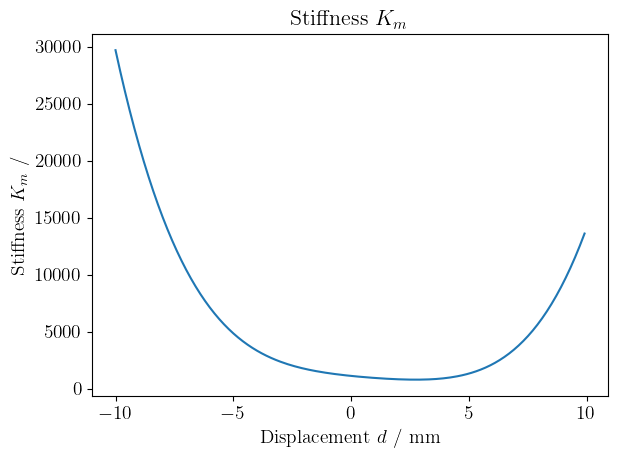

In [ ]:
x = np.arange(-10e-3, 10e-3, 1e-4)
y = poly_Bl(x)
engutil.plot_time_series([(x*1e3,y)], ylabel="Force factor $Bl$ / Tm", xlabel="Displacement $d$ / mm", title="Force Factor $Bl$")

x = np.arange(-10e-3, 10e-3, 1e-4)
y = poly_Le(x) # poly_li
engutil.plot_time_series([(x*1e3,y)], ylabel="Inductance $L_e$ / H", xlabel="Displacement $d$ / mm", title="Inductance $L_e$")


x = np.arange(-10e-3, 10e-3, 1e-4)
y = poly_K(x)
engutil.plot_time_series([(x*1e3,y)], ylabel="Stiffness $K_m$ / ", xlabel="Displacement $d$ / mm", title="Stiffness $K_m$")

